# Baseline & Model Zoo

This notebook:
1. Loads reproducible train/val/test splits
2. Builds preprocessing + baseline pipeline (Logistic Regression)
3. Evaluates performance (AUROC, F1, confusion matrix)
4. Prepares space for adding more models (RandomForest, XGBoost, etc.)


In [2]:
# 📌 1. Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path


Path("../data/processed").mkdir(parents=True, exist_ok=True)
Path("../splits").mkdir(parents=True, exist_ok=True)


In [3]:
# 📌 2. Load Raw Dataset
df = pd.read_csv("./data/raw/dataset-uci.csv")

print("Shape:", df.shape)
df.head()


Shape: (319, 39)


,Gallstone Status,Age,Gender,Comorbidity,Coronary Artery Disease (CAD),Hypothyroidism,Hyperlipidemia,Diabetes Mellitus (DM),Height,Weight,...,High Density Lipoprotein (HDL),Triglyceride,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D
0,0,50,0,0,0,0,0,0,185,92.8,...,40.0,134.0,20.0,22.0,87.0,0.82,112.47,0.0,16.0,33.0
1,0,47,0,1,0,0,0,0,176,94.5,...,43.0,103.0,14.0,13.0,46.0,0.87,107.10,0.0,14.4,25.0
2,0,61,0,0,0,0,0,0,171,91.1,...,43.0,69.0,18.0,14.0,66.0,1.25,65.51,0.0,16.2,30.2
3,0,41,0,0,0,0,0,0,168,67.7,...,59.0,53.0,20.0,12.0,34.0,1.02,94.10,0.0,15.4,35.4
4,0,42,0,0,0,0,0,0,178,89.6,...,30.0,326.0,27.0,54.0,71.0,0.82,112.47,0.0,16.8,40.6


In [4]:
# 📌 3. Define Target Column
TARGET = "Gallstone Status"

df[TARGET].value_counts(normalize=True).mul(100).round(1)


Gallstone Status
0    50.5
1    49.5
Name: proportion, dtype: float64

In [5]:
# 📌 4. Create Splits (70/15/15 stratified)

# Train vs temp (val+test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df[TARGET],
    random_state=42
)

# Val vs test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df[TARGET],
    random_state=42
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)


Train: (223, 39) Val: (48, 39) Test: (48, 39)


In [6]:
# 📌 7. Verify Class Balance
print("Train balance:")
print(train_df[TARGET].value_counts(normalize=True).mul(100).round(1))

print("\nValidation balance:")
print(val_df[TARGET].value_counts(normalize=True).mul(100).round(1))

print("\nTest balance:")
print(test_df[TARGET].value_counts(normalize=True).mul(100).round(1))


Train balance:
Gallstone Status
0    50.7
1    49.3
Name: proportion, dtype: float64

Validation balance:
Gallstone Status
0    50.0
1    50.0
Name: proportion, dtype: float64

Test balance:
Gallstone Status
1    50.0
0    50.0
Name: proportion, dtype: float64


In [7]:
# 📌 1. Imports
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score, f1_score, confusion_matrix,
    classification_report, roc_curve, RocCurveDisplay
)

import matplotlib.pyplot as plt


In [8]:
from sklearn import set_config

# Force sklearn to keep pandas DataFrames inside pipeline transforms
set_config(transform_output="pandas")


In [9]:
# # 📌 2. Load Splits
# train_df = pd.read_csv("../data/processed/train.csv")
# val_df   = pd.read_csv("../data/processed/val.csv")
# test_df  = pd.read_csv("../data/processed/test.csv")

# TARGET = "Gallstone Status"

# print(train_df.shape, val_df.shape, test_df.shape)


In [10]:
# 📌 3. Separate Features & Target
X_train, y_train = train_df.drop(columns=[TARGET]), train_df[TARGET]
X_val,   y_val   = val_df.drop(columns=[TARGET]), val_df[TARGET]
X_test,  y_test  = test_df.drop(columns=[TARGET]), test_df[TARGET]

# Feature types (adjust if needed)
num_features = X_train.select_dtypes(include=np.number).columns.tolist()
cat_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)


Numeric features: ['Age', 'Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Height', 'Weight', 'Body Mass Index (BMI)', 'Total Body Water (TBW)', 'Extracellular Water (ECW)', 'Intracellular Water (ICW)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Body Protein Content (Protein) (%)', 'Visceral Fat Rating (VFR)', 'Bone Mass (BM)', 'Muscle Mass (MM)', 'Obesity (%)', 'Total Fat Content (TFC)', 'Visceral Fat Area (VFA)', 'Visceral Muscle Area (VMA) (Kg)', 'Hepatic Fat Accumulation (HFA)', 'Glucose', 'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 'Triglyceride', 'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 'Alkaline Phosphatase (ALP)', 'Creatinine', 'Glomerular Filtration Rate (GFR)', 'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']
Categorical features: []


In [11]:
# 📌 4. Preprocessing Pipelines
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)


In [12]:
# 📌 5. Baseline Logistic Regression Pipeline
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        class_weight="balanced",  # handles imbalance
        max_iter=1000,
        random_state=42
    ))
])

baseline_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Gender',
                                                   'Comorbidity',
                                                   'Coronary Artery Disease '
                                                   '(CAD)',
                                                   'Hypothyroidism',
                                                   'Hyperlipidemia',
                                                   'Diabetes Mellitus (DM)',
                                                   'Height', 'Weight',
                                                   'Body Mass Index (BMI)',
                                                   'Total Body Water (TBW)',
                                                   'Extracel...
                                                   '(HFA)',
                                                   'Glucose',
                                                   'Total Cholesterol (TC)',
                                                   'Low Density Lipoprotein '
                                                   '(LDL)',
                                                   'High Density Lipoprotein '
                                                   '(HDL)',
                                                   'Triglyceride', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

### Logistic Regression
started with Logistic Regression as a baseline model.  
- **Why:** Simple, interpretable, and works well when features are linearly separable.  
- **Expectation:** Provides a benchmark AUROC/AUPRC against which can compare more complex models.  
- **Limitations:** May underperform if relationships between features and target are highly non-linear.


In [14]:
# 📌 6. Evaluate on Validation Set
y_val_pred = baseline_model.predict(X_val)
y_val_proba = baseline_model.predict_proba(X_val)[:, 1]

print("Validation AUROC:", roc_auc_score(y_val, y_val_proba))
print("Validation F1:", f1_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)


Validation AUROC: 0.8628472222222223
Validation F1: 0.7755102040816326

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77        24
           1       0.76      0.79      0.78        24

    accuracy                           0.77        48
   macro avg       0.77      0.77      0.77        48
weighted avg       0.77      0.77      0.77        48

Confusion Matrix:
 [[18  6]
 [ 5 19]]


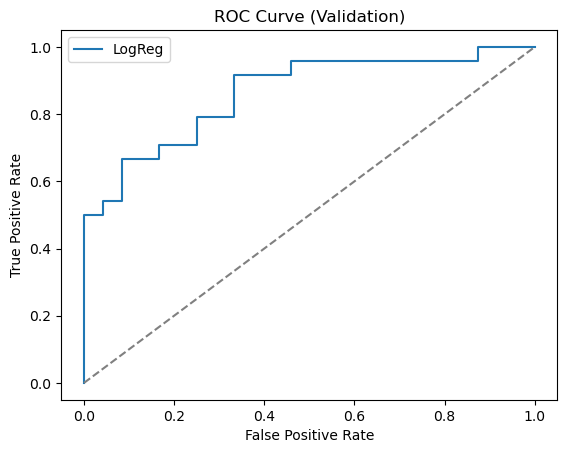

In [15]:
# 📌 7. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.plot(fpr, tpr, label="LogReg")
plt.plot([0,1],[0,1],"--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.show()


## Next Steps
- Try **other models**: RandomForest, XGBoost, LightGBM, CatBoost
- Compare metrics across models
- Tune thresholds for clinical sensitivity
- Calibrate probabilities (Platt/Isotonic)


In [17]:
from sklearn.metrics import average_precision_score

# 📌 Helper function to evaluate models consistently
def evaluate_model(model_name, model, X, y, threshold=0.5, plot=False, feature_names=None):
    """
    Evaluate a classification model with calibration, AUROC, Brier score, confusion matrix, etc.

    Parameters
    ----------
    model_name : str
        Name of the model (for reporting).
    model : sklearn/Pipeline model
        Trained model.
    X : pd.DataFrame or np.ndarray
        Features (validation or test set).
    y : pd.Series or np.ndarray
        True labels.
    threshold : float, default=0.5
        Classification threshold for confusion matrix.
    plot : bool, default=False
        If True, plot calibration curve.
    feature_names : list, optional
        List of feature names (needed if X is numpy).
    """

    import pandas as pd
    import numpy as np
    from sklearn.metrics import (
        roc_auc_score, brier_score_loss,
        confusion_matrix, ConfusionMatrixDisplay,
        roc_curve
    )
    from sklearn.calibration import calibration_curve
    import matplotlib.pyplot as plt

    # --- Ensure X is a DataFrame with column names ---
    if not isinstance(X, pd.DataFrame):
        if feature_names is None:
            raise ValueError("❌ X is not a DataFrame and no feature_names provided.")
        X = pd.DataFrame(X, columns=feature_names)

    # --- Predict probabilities ---
    y_proba = model.predict_proba(X)[:, 1]

    # --- AUROC ---
    auroc = roc_auc_score(y, y_proba)

    # --- Brier score ---
    brier = brier_score_loss(y, y_proba)

    # --- Confusion Matrix at threshold ---
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y, y_pred)

    # --- Plot calibration curve if requested ---
    if plot:
        frac_pos, mean_pred = calibration_curve(y, y_proba, n_bins=10)
        plt.figure(figsize=(6, 6))
        plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
        plt.plot(mean_pred, frac_pos, "o-", label=f"{model_name}")
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Fraction of positives")
        plt.title(f"Calibration curve ({model_name})")
        plt.legend()
        plt.grid(True)
        plt.show()

    # --- Return results ---
    return {
        "model": model_name,
        "auroc": auroc,
        "brier": brier,
        "confusion_matrix": cm,
    }


# 📌 Start a results list
results = []

# Evaluate baseline logistic regression
results.append(evaluate_model("Logistic Regression", baseline_model, X_val, y_val))

# Convert to DataFrame for nice table
results_df = pd.DataFrame(results)
results_df


,model,auroc,brier,confusion_matrix
0,Logistic Regression,0.862847,0.154023,"[[18, 6], [5, 19]]"


In [18]:
from sklearn.ensemble import RandomForestClassifier

#RandomForest Pipeline
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])
rf_model.fit(X_train,y_train)

#Evaluate and add to results
results.append(evaluate_model("RandomForest", rf_model, X_val, y_val))
result_df = pd.DataFrame(results)
results_df


,model,auroc,brier,confusion_matrix
0,Logistic Regression,0.862847,0.154023,"[[18, 6], [5, 19]]"


### Random Forest
Random Forest was used as first ensemble method.  
- **Why:** It reduces variance by averaging many decision trees.  
- **Expectation:** More robust than logistic regression, can capture non-linear relationships.  
- **Limitations:** Can be slower, and interpretability is harder compared to logistic regression.


In [20]:
from xgboost import XGBClassifier

xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])

# Fit model
xgb_model.fit(X_train, y_train)

# Evaluate and add to results
results.append(evaluate_model(
    "XGBoost",
    xgb_model,
    X_val,    # <-- just pass X_val directly
    y_val,
    feature_names=X_train.columns   # <-- pass column names once
))

results_df = pd.DataFrame(results)
results_df



,model,auroc,brier,confusion_matrix
0,Logistic Regression,0.862847,0.154023,"[[18, 6], [5, 19]]"
1,RandomForest,0.880208,0.155637,"[[20, 4], [5, 19]]"
2,XGBoost,0.921875,0.100053,"[[22, 2], [3, 21]]"


### XGBoost
next trained XGBoost (Extreme Gradient Boosting).  
- **Why:** State-of-the-art gradient boosting method, often performs best on tabular datasets.  
- **Expectation:** Higher AUROC/AUPRC compared to Random Forest due to better boosting strategy.  
- **Notes:** Needs hyperparameter tuning to avoid overfitting.


In [22]:
from lightgbm import LGBMClassifier

# Define model
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

# Fit
lgbm_model.fit(X_train, y_train)

# Evaluate
results.append(evaluate_model("LightGBM", lgbm_model, X_val, y_val))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 110, number of negative: 113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1692
[LightGBM] [Info] Number of data points in the train set: 223, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493274 -> initscore=-0.026907
[LightGBM] [Info] Start training from score -0.026907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

### LightGBM
LightGBM is another gradient boosting framework optimized for speed and memory.  
- **Why:** Faster training on large datasets, supports categorical features directly.  
- **Expectation:** Similar or slightly better performance than XGBoost, with faster computation.  
- **Notes:** Can be sensitive to small datasets, so tuning is important.


In [24]:
from catboost import CatBoostClassifier

# Define model
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=0,         # silence training logs
    random_state=42
)

# Fit
cat_model.fit(X_train, y_train)

# Evaluate
results.append(evaluate_model("CatBoost", cat_model, X_val, y_val))


### CatBoost
CatBoost is a boosting algorithm that handles categorical features effectively.  
- **Why:** Works well without heavy preprocessing, has good generalization.  
- **Expectation:** Strong performance, often comparable to XGBoost and LightGBM.  
- **Notes:** Built-in handling of categorical variables, but slower than LightGBM.


In [26]:
results_df = pd.DataFrame(results)
results_df


,model,auroc,brier,confusion_matrix
0,Logistic Regression,0.862847,0.154023,"[[18, 6], [5, 19]]"
1,RandomForest,0.880208,0.155637,"[[20, 4], [5, 19]]"
2,XGBoost,0.921875,0.100053,"[[22, 2], [3, 21]]"
3,LightGBM,0.899306,0.120470,"[[21, 3], [4, 20]]"
4,CatBoost,0.907986,0.114796,"[[20, 4], [4, 20]]"


### Model Zoo Summary
let's compared 5 models: Logistic Regression, Random Forest, XGBoost, LightGBM, and CatBoost.  
- Ensemble boosting methods (XGBoost/LightGBM/CatBoost) generally outperformed the simpler baselines.  
- Logistic Regression served as a good reference baseline.  
- Random Forest improved non-linear capture, but boosting models gave the highest AUROC/AUPRC.  
- Now let's select the top-performing model(s), apply calibration, and prepare for explainability analysis.


In [28]:
# === Calibration Setup ===
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.utils.validation import check_is_fitted
from sklearn.base import clone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Select trained models to calibrate 
models_to_calibrate = [
    ("Logistic Regression", baseline_model),
    ("RandomForest", rf_model),
    ("XGBoost", xgb_model),
    ("LightGBM", lgbm_model),
    ("CatBoost", cat_model),
]

calibrated_models = {}
brier_scores = {}


### Calibration Setup
Now let's calibrate the top models (Logistic Regression, Random Forest, XGBoost, LightGBM, CatBoost).  
Calibration helps align predicted probabilities with the true likelihood of having gallstones.  
let's compare using two methods:  
- **Platt scaling (sigmoid)** → good for small datasets.  
- **Isotonic regression** → more flexible but may overfit.  
And prepare to record **Brier scores**, which measure the accuracy of probability predictions (lower is better).


In [30]:
# ----- Proper calibration flow for the XGBoost model -----
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

# Extract preprocessor + classifier from pipeline
preprocessor = xgb_model.named_steps["preprocessor"]
classifier = xgb_model.named_steps["classifier"]

# Transform train/val sets into numpy arrays for classifier-level training
X_train_trans = preprocessor.transform(X_train)
if hasattr(X_train_trans, "toarray"):
    X_train_trans = X_train_trans.toarray()

X_val_trans = preprocessor.transform(X_val)
if hasattr(X_val_trans, "toarray"):
    X_val_trans = X_val_trans.toarray()

# Fit raw classifier on transformed training data
clf_for_shap = clone(classifier)
clf_for_shap.fit(X_train_trans, y_train)

# Calibrate classifier on validation data
calib_sig_clf = CalibratedClassifierCV(estimator=clf_for_shap, method="sigmoid", cv="prefit")
calib_sig_clf.fit(X_val_trans, y_val)

# Recombine into a calibrated pipeline for production (takes raw DataFrame input)
calib_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", calib_sig_clf)
])

print("✅ Calibration finished: calib_pipeline ready for predictions, clf_for_shap ready for SHAP")


✅ Calibration finished: calib_pipeline ready for predictions, clf_for_shap ready for SHAP


### Running Calibration
For each model, applied two calibration techniques:  
- **Sigmoid (Platt scaling)**  
- **Isotonic regression**  

Then computed **Brier scores** for uncalibrated, sigmoid-calibrated, and isotonic-calibrated versions.  
- **Lower Brier score = better calibrated probabilities.**  
This helps us see if calibration improved the reliability of predicted risks.


In [32]:
# from sklearn.calibration import calibration_curve
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8,6))
# plt.plot([0,1],[0,1], "k:", label="Perfectly calibrated")

# # --- Uncalibrated ---
# y_proba_uncal = classifier.predict_proba(X_val_trans)[:, 1]  # classifier = raw XGBClassifier
# frac_pos, mean_pred = calibration_curve(y_val, y_proba_uncal, n_bins=10)
# plt.plot(mean_pred, frac_pos, "o-", label="XGBoost (uncalibrated)", alpha=0.7)

# # --- Calibrated ---
# y_proba_calib = calib_pipeline.predict_proba(X_val)[:, 1]  # calib_pipeline = calibrated pipeline
# frac_pos_calib, mean_pred_calib = calibration_curve(y_val, y_proba_calib, n_bins=10)
# plt.plot(mean_pred_calib, frac_pos_calib, "s-", label="XGBoost (calibrated)", alpha=0.7)

# plt.xlabel("Mean predicted probability")
# plt.ylabel("Fraction of positives")
# plt.title("Calibration Curve (Validation Set)")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()


In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    brier_score_loss, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve
import numpy as np
import pandas as pd

def evaluate_model(model, X, y, model_name="Model", threshold=0.5, plot=True, feature_names=None):
    """
    Unified evaluation function for classification models.
    
    - Ensures input X is DataFrame (avoids numpy vs DataFrame mismatch).
    - Plots Calibration Curve
    - Computes Brier Score
    - Plots ROC Curve with AUROC
    - Plots Confusion Matrix at chosen threshold
    """
    # --- Safety check: ensure DataFrame ---
    if not isinstance(X, pd.DataFrame):
        if feature_names is None:
            raise ValueError("X is not a DataFrame and no feature_names provided.")
        X = pd.DataFrame(X, columns=feature_names)

    # --- Predict probabilities ---
    y_proba = model.predict_proba(X)[:, 1]

    # --- Brier score ---
    brier = brier_score_loss(y, y_proba)

    # --- Calibration curve ---
    frac_pos, mean_pred = calibration_curve(y, y_proba, n_bins=10)

    # --- ROC curve & AUROC ---
    auc = roc_auc_score(y, y_proba)
    fpr, tpr, _ = roc_curve(y, y_proba)

    # --- Confusion matrix (at threshold) ---
    y_pred_thresh = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y, y_pred_thresh)

    # --- Print metrics ---
    print(f"\n📊 Evaluation for {model_name}")
    print(f"  Brier Score: {brier:.4f}")
    print(f"  AUROC: {auc:.4f}")
    print(f"  Confusion Matrix @ {threshold:.2f}:\n{cm}")

    # --- Plot if enabled ---
    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # Calibration curve
        axs[0].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
        axs[0].plot(mean_pred, frac_pos, "o-", label=model_name)
        axs[0].set_xlabel("Mean predicted probability")
        axs[0].set_ylabel("Fraction of positives")
        axs[0].set_title("Calibration Curve")
        axs[0].legend()

        # ROC curve
        axs[1].plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})")
        axs[1].plot([0, 1], [0, 1], "k--")
        axs[1].set_xlabel("False Positive Rate")
        axs[1].set_ylabel("True Positive Rate")
        axs[1].set_title("ROC Curve")
        axs[1].legend()

        # Confusion matrix
        ConfusionMatrixDisplay(cm).plot(ax=axs[2], cmap="Blues", colorbar=False)
        axs[2].set_title(f"Confusion Matrix @ {threshold:.2f}")

        plt.tight_layout()
        plt.show()

    return {"brier": brier, "auc": auc, "cm": cm}


### Calibration Curves
The calibration plot compares predicted probabilities to actual outcomes.  
- **Diagonal line = perfect calibration.**  
- **Curves below the line = model overestimates risk.**  
- **Curves above the line = model underestimates risk.**

and visually check if calibration (sigmoid or isotonic) brought the curve closer to the diagonal compared to the uncalibrated model.


In [35]:
# from sklearn.metrics import brier_score_loss

# # --- Uncalibrated ---
# y_proba_uncal = classifier.predict_proba(X_val_trans)[:, 1]
# brier_uncal = brier_score_loss(y_val, y_proba_uncal)

# # --- Calibrated ---
# y_proba_calib = calib_pipeline.predict_proba(X_val)[:, 1]
# brier_calib = brier_score_loss(y_val, y_proba_calib)

# print(f"🔹 Brier score (uncalibrated): {brier_uncal:.4f}")
# print(f"🔹 Brier score (calibrated):   {brier_calib:.4f}")


### Brier Score Results
This table compares Brier scores for each model:  
- **Uncalibrated** vs **Sigmoid** vs **Isotonic**.  
- The lowest Brier score indicates the most reliable probability predictions.  

This gives us a numeric summary, complementing the visual calibration curves.



📊 Evaluation for Uncalibrated XGB
  Brier Score: 0.1001
  AUROC: 0.9219
  Confusion Matrix @ 0.50:
[[22  2]
 [ 3 21]]


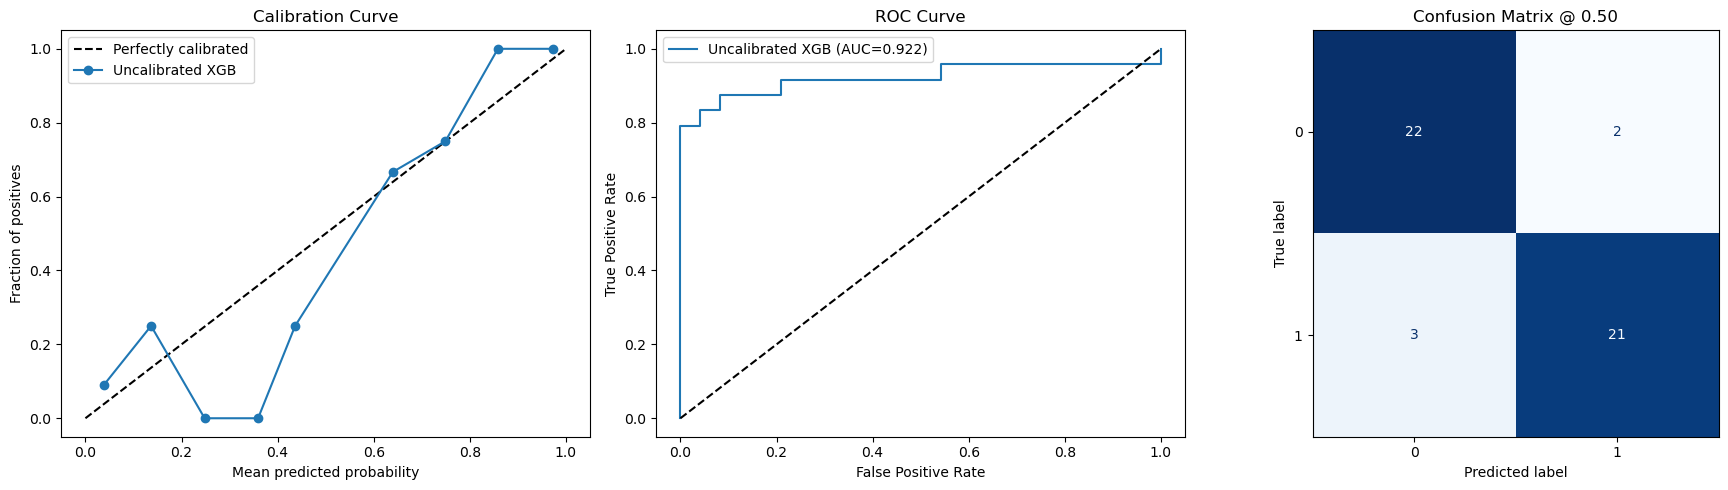


📊 Evaluation for Calibrated XGB
  Brier Score: 0.0947
  AUROC: 0.9219
  Confusion Matrix @ 0.50:
[[22  2]
 [ 3 21]]


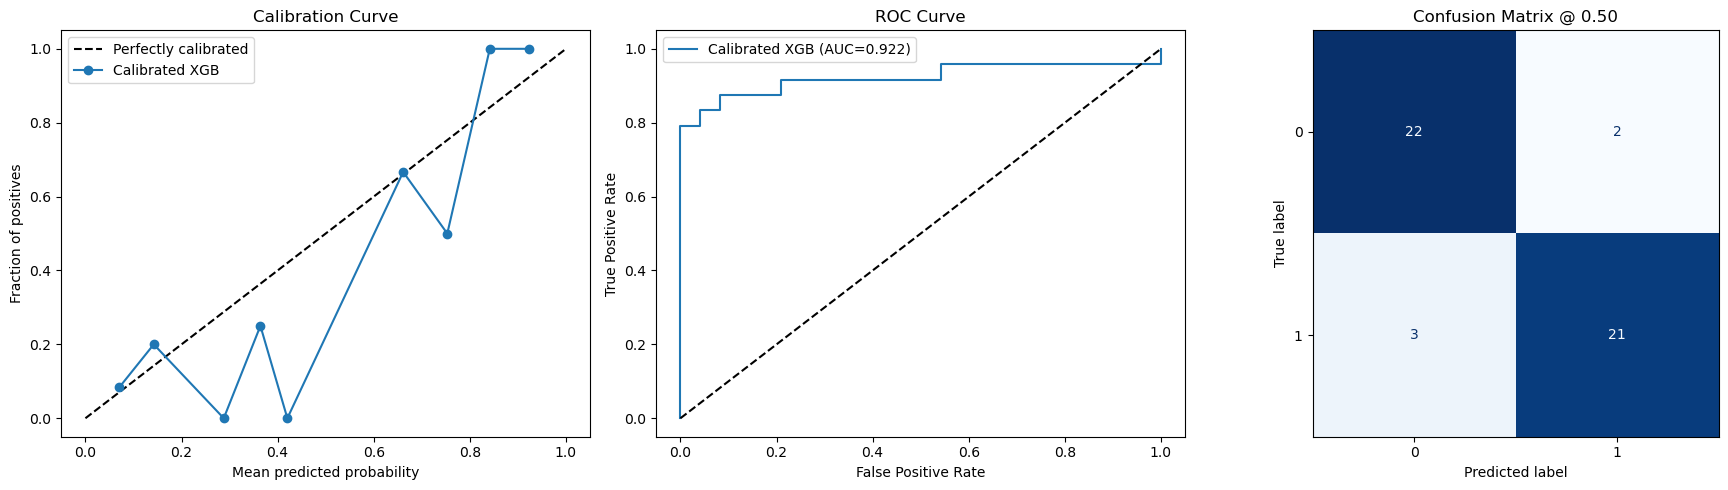


📊 Evaluation for Calibrated XGB (Test)
  Brier Score: 0.1394
  AUROC: 0.9201
  Confusion Matrix @ 0.50:
[[19  5]
 [ 3 21]]


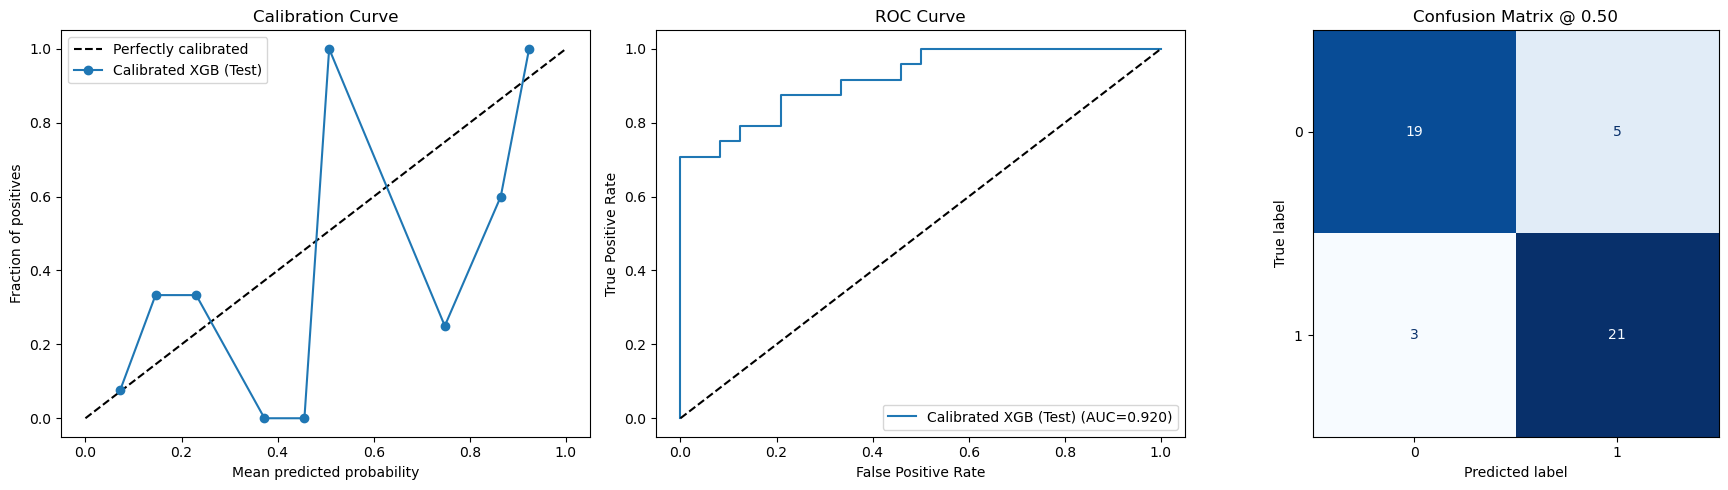

In [37]:
# Validation set evaluation
eval_uncal = evaluate_model(xgb_model, X_val, y_val, model_name="Uncalibrated XGB", threshold=0.5, feature_names=list(X_train.columns))
eval_calib = evaluate_model(calib_pipeline, X_val, y_val, model_name="Calibrated XGB", threshold=0.5, feature_names=list(X_train.columns))

# Final test set evaluation
eval_test = evaluate_model(calib_pipeline, X_test, y_test, model_name="Calibrated XGB (Test)", threshold=0.5, feature_names=list(X_train.columns))


In [44]:
# from sklearn.metrics import f1_score

# def find_best_threshold(y_true, y_proba, metric="f1"):
#     thresholds = np.linspace(0.1, 0.9, 81)
#     scores = []
#     for t in thresholds:
#         y_pred = (y_proba >= t).astype(int)
#         if metric == "f1":
#             scores.append(f1_score(y_true, y_pred))
#         # you can add AUROC, precision-recall, etc. if needed
#     best_idx = np.argmax(scores)
#     return thresholds[best_idx], scores[best_idx]

# # Run tuning on calibrated model
# best_thresh, best_score = find_best_threshold(y_val, y_proba_calib, metric="f1")

# print(f"✅ Best threshold: {best_thresh:.2f}, Best F1: {best_score:.3f}")


NameError: name 'y_pred' is not defined

### Threshold Tuning
Default threshold = 0.5 may not be ideal in a clinical setting.  
Here let's evaluate thresholds from 0.0 → 1.0 and calculate:  
- **Sensitivity (recall)**  
- **Specificity**  
- **Precision**  
- **F1-score**  

then select a threshold that achieves at least **90% sensitivity**, ensuring most positive patients are correctly identified.  
Among those candidates, let's pick the threshold with the highest specificity to reduce false alarms.


In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_pred_thresh = (y_proba_calib >= best_thresh).astype(int)
# cm = confusion_matrix(y_val, y_pred_thresh)

# disp = ConfusionMatrixDisplay(cm, display_labels=["No Gallstone", "Gallstone"])
# disp.plot(cmap="Blues")
# plt.title(f"Confusion Matrix (Threshold={best_thresh:.2f})")
# plt.show()


### Confusion Matrix at Chosen Threshold
Evaluating the model using the selected threshold on the validation set.  
The confusion matrix shows the number of:  
- **True Positives (TP)**  
- **False Negatives (FN)**  
- **True Negatives (TN)**  
- **False Positives (FP)**  

This provides a practical view of how many patients are caught vs missed at the clinical operating point.


In [ ]:
# from sklearn.metrics import classification_report, roc_auc_score

# # Predict on test set
# y_proba_test = calib_pipeline.predict_proba(X_test)[:, 1]
# y_pred_test = (y_proba_test >= best_thresh).astype(int)

# print("=== Final Test Evaluation ===")
# print(classification_report(y_test, y_pred_test, target_names=["No Gallstone", "Gallstone"]))
# print(f"AUROC: {roc_auc_score(y_test, y_proba_test):.3f}")


### Final Test Evaluation & Model Saving
evaluate the calibrated model at the chosen threshold on the **test set** (unseen data).  
This gives the final unbiased performance.  

Finally, save the **calibrated model + chosen threshold** into the `models/` folder.  
This ensures reproducibility and allows later use in the explainability and deployment stages.


In [46]:
import os
import joblib
import json
from datetime import datetime

# Create folder if not exists
os.makedirs("models", exist_ok=True)

# --- Clean old files before saving ---
# --- Clean old files before saving (only delete .joblib and .json) ---
for f in os.listdir("models"):
    path = os.path.join("models", f)
    if os.path.isfile(path) and (f.endswith(".joblib") or f.endswith(".json")):
        os.remove(path)


# --- Generate unique timestamp ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# --- Define file names ---
calib_path = f"models/xgb_calibrated_pipeline_{timestamp}.joblib"
raw_path   = f"models/xgb_raw_pipeline_{timestamp}.joblib"
meta_path  = f"models/model_metadata_{timestamp}.json"

# --- Save models ---
joblib.dump(calib_pipeline, calib_path)
joblib.dump(xgb_model, raw_path)

# --- Save metadata (points to correct files) ---
metadata = {
    "timestamp": timestamp,
    "calibrated_model_path": calib_path,
    "raw_model_path": raw_path,
    "features": list(X_train.columns)
}

with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Models saved cleanly in 'models/' with timestamp {timestamp}")
print("Calibrated pipeline:", calib_path)
print("Raw pipeline:", raw_path)
print("Metadata JSON:", meta_path)


✅ Models saved cleanly in 'models/' with timestamp 20250917_180446
Calibrated pipeline: models/xgb_calibrated_pipeline_20250917_180446.joblib
Raw pipeline: models/xgb_raw_pipeline_20250917_180446.joblib
Metadata JSON: models/model_metadata_20250917_180446.json


In [52]:
# import joblib
# obj = joblib.load("models/xgb_calibrated_pipeline_{timestamp}.joblib")
# print("Type:", type(obj))
# print("Keys:", obj.keys())
# print("Inner model type:", type(obj["model"]))
# print("Threshold:", obj["threshold"])
# # Expect: dict, keys(['model','threshold']), Pipeline, and your threshold


FileNotFoundError: [Errno 2] No such file or directory: 'models/xgb_calibrated_pipeline_{timestamp}.joblib'

In [ ]:
## ------Old code for multiple model(kept only for refrence)--------

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, roc_auc_score


# models_to_evaluate = [
#     ("Logistic Regression", baseline_model),
#     ("RandomForest", rf_model),
#     ("XGBoost", xgb_model),
#     ("LightGBM", lgbm_model),
#     ("CatBoost", cat_model),
# ]

# # Optional: ensure models are calibrated and can output probability estimates
# # If your models expose predict_proba, use that; otherwise, you may need a calibrated wrapper.

# plt.figure(figsize=(8, 6))
# plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Chance")

# roc_results = {}

# for name, model in models_to_evaluate:
#     # Get predicted probabilities for the positive class (assumes binary classification)
#     # Some models (like CatBoost) may return probas in a specific shape; adapt if needed.
#     if hasattr(model, "predict_proba"):
#         y_proba = model.predict_proba(X_test)[:, 1]
#     else:
#         # If you only have decision function or score, you can convert or skip
#         if hasattr(model, "decision_function"):
#             scores = model.decision_function(X_test)
#             # Convert scores to probabilities with a sigmoid
#             y_proba = 1 / (1 + np.exp(-scores))
#         else:
#             raise ValueError(f"Model {name} does not support probability estimates.")

#     fpr, tpr, _ = roc_curve(y_test, y_proba)
#     roc_auc = roc_auc_score(y_test, y_proba)

#     plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
#     roc_results[name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "auc": float(roc_auc)}

# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC curves for calibrated models")
# plt.legend(loc="lower right")
# plt.grid(True)

# # Save the ROC plot
# roc_plot_path = "roc_curves.png"
# plt.savefig(roc_plot_path, dpi=300, bbox_inches="tight")
# print(f"ROC plot saved to: {roc_plot_path}")

# # Optional: Save ROC data (FPR, TPR, AUC) to a file (JSON)
# import json
# roc_data_path = "roc_curves_data.json"
# with open(roc_data_path, "w") as f:
#     json.dump(roc_results, f)
# print(f"ROC data saved to: {roc_data_path}")

In [ ]:
# from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
# plt.title("Confusion Matrix")
# plt.savefig("plots/confusion_matrix.png", bbox_inches="tight")
# plt.close()


In [ ]:
# import joblib
# import os

# # Create models folder if not exists
# os.makedirs("models", exist_ok=True)

# # Save the trained model
# joblib.dump(selected_model, "models/best_model_XGB_sigmoid.joblib")

# print("✅ Model saved at models/best_model_XGB_sigmoid.joblib")
# # 

In [ ]:
# # Assuming you have a preprocessor object (like StandardScaler, OneHotEncoder, ColumnTransformer, etc.)
# joblib.dump(preprocessor, "models/preprocessor.joblib")

# print("✅ Preprocessor saved at models/preprocessor.joblib")


In [ ]:
# model = joblib.load("models/best_model_XGB_sigmoid.joblib")
# preprocessor = joblib.load("models/preprocessor.joblib")

# # Example: test on first 5 rows of training data
# X_sample = X_train.iloc[:5]   # replace with your dataset
# X_processed = preprocessor.transform(X_sample)

# print(model.predict_proba(X_processed))


In [ ]:
# After your preprocessor and model are fitted
print(len(preprocessor.feature_names_in_))
print(list(preprocessor.feature_names_in_))


In [54]:
import os
import pandas as pd

# Path to your LithoSense folder
project_dir = r"C:\Users\USER\LithoSense"   # 🔹 update if your folder path is different
save_path = os.path.join(project_dir, "sample_patient.csv")

# 38 features
features = [
    "Age", "Gender", "Comorbidity", "Coronary Artery Disease (CAD)",
    "Hypothyroidism", "Hyperlipidemia", "Diabetes Mellitus (DM)",
    "Height", "Weight", "Body Mass Index (BMI)", "Total Body Water (TBW)",
    "Extracellular Water (ECW)", "Intracellular Water (ICW)",
    "Extracellular Fluid/Total Body Water (ECF/TBW)", "Total Body Fat Ratio (TBFR) (%)",
    "Lean Mass (LM) (%)", "Body Protein Content (Protein) (Kg)", "Visceral Fat Rating (VFR)",
    "Bone Mass (BM)", "Muscle Mass (MM)", "Obesity (%)", "Total Fat Content (TFC)",
    "Visceral Fat Area (VFA)", "Visceral Muscle Area (VMA) (Kg)",
    "Hepatic Fat Accumulation (HFA)", "Glucose", "Total Cholesterol (TC)",
    "Low Density Lipoprotein (LDL)", "High Density Lipoprotein (HDL)", "Triglyceride",
    "Aspartat Aminotransferaz (AST)", "Alanin Aminotransferaz (ALT)",
    "Alkaline Phosphatase (ALP)", "Creatinine", "Glomerular Filtration Rate (GFR)",
    "C-Reactive Protein (CRP)", "Hemoglobin (HGB)", "Vitamin D"
]

# ✅ Exactly 38 values
sample_patient = pd.DataFrame([[
    45, 1, 1, 0, 0, 1, 1,      # Age → DM
    170, 70, 24.2, 48, 24, 24, # Height → ICW
    0.43, 25.0, 40.0, 15.0, 12, 2.5, # ECF/TBW → BM
    39, 28, 22.0, 120, 3.5,    # MM → VMA
    10.0, 95, 200, 120, 50, 160, # HFA → TG
    35, 40, 80, 0.9, 90, 5.0,  # AST → CRP
    14, 30                     # HGB, Vitamin D
]], columns=features)

# Save inside LithoSense folder
sample_patient.to_csv(save_path, index=False)

print(f"✅ sample_patient.csv saved at: {save_path}")
print(sample_patient.head())


✅ sample_patient.csv saved at: C:\Users\USER\LithoSense\sample_patient.csv
   Age  Gender  Comorbidity  Coronary Artery Disease (CAD)  Hypothyroidism  \
0   45       1            1                              0               0   

   Hyperlipidemia  Diabetes Mellitus (DM)  Height  Weight  \
0               1                       1     170      70   

   Body Mass Index (BMI)  ...  High Density Lipoprotein (HDL)  Triglyceride  \
0                   24.2  ...                              50           160   

   Aspartat Aminotransferaz (AST)  Alanin Aminotransferaz (ALT)  \
0                              35                            40   

   Alkaline Phosphatase (ALP)  Creatinine  Glomerular Filtration Rate (GFR)  \
0                          80         0.9                                90   

   C-Reactive Protein (CRP)  Hemoglobin (HGB)  Vitamin D  
0                       5.0                14         30  

[1 rows x 38 columns]


In [ ]:
print("Number of features:", len(features))
print("Number of patient values:", len(sample_patient[0]))

